# PyTorch Computer Vision MNIST Digits Classification

Author: Sufiyaan Usmani

Link: [GitHub](https://github.com/sufiyaanusmani/PyTorch-Computer-Vision-MNIST-Digits-Classification)

# Importing Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Setting up Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Getting a Dataset

Using MNIST Dataset

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Visualizing Data

Text(0.5, 1.0, '5 - five')

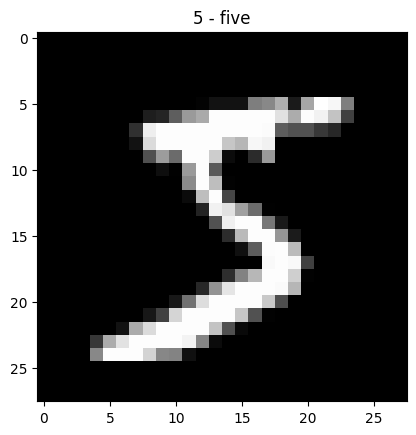

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

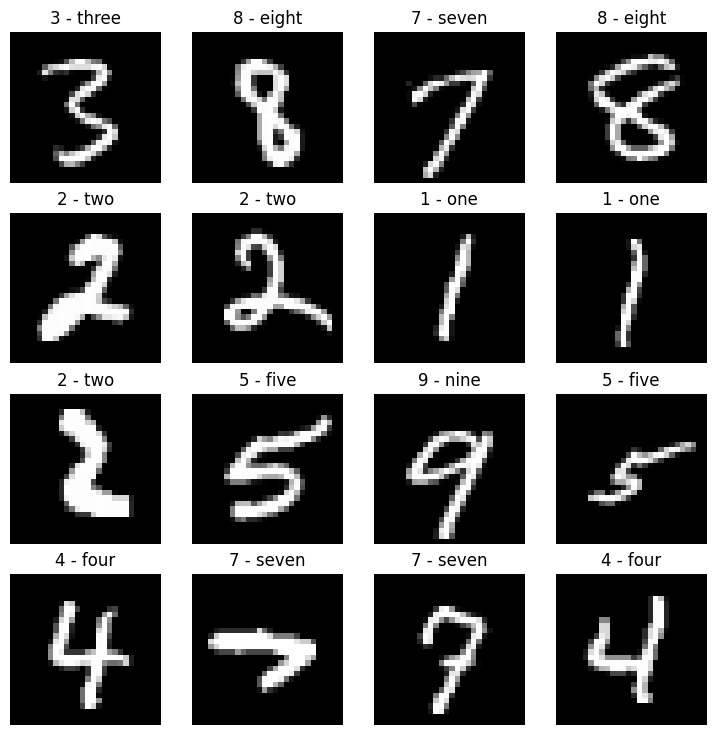

In [8]:
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Preparing DataLoader

In [9]:
from torch.utils.data import DataLoader

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Building Model

Using TinyVGG

In [11]:
def TinyVGG(input_shape: int, hidden_units: int, output_shape: int):
  return nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
  )

In [12]:
model = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=490, out_features=10, bias=True)
)

## Train Step

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device=device):
  train_loss, train_acc = 0, 0
  model = model.to(device)
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f} %")

In [15]:
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device=device):
  test_loss, test_acc = 0, 0
  model = model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f} %")

# Setting up loss function and optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Train Test Loop

In [17]:
from tqdm.auto import tqdm

In [18]:
epochs = 10

In [19]:
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------------")
  train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_score, device=device)
  test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_score, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------------
Train Loss: 0.26906 | Train Accuracy: 0.91 %
Test Loss: 0.06224 | Test Accuracy: 0.98 %
Epoch: 1
---------------
Train Loss: 0.06830 | Train Accuracy: 0.98 %
Test Loss: 0.06716 | Test Accuracy: 0.98 %
Epoch: 2
---------------
Train Loss: 0.05411 | Train Accuracy: 0.98 %
Test Loss: 0.05236 | Test Accuracy: 0.98 %
Epoch: 3
---------------
Train Loss: 0.04602 | Train Accuracy: 0.99 %
Test Loss: 0.04271 | Test Accuracy: 0.99 %
Epoch: 4
---------------
Train Loss: 0.04066 | Train Accuracy: 0.99 %
Test Loss: 0.04345 | Test Accuracy: 0.99 %
Epoch: 5
---------------
Train Loss: 0.03751 | Train Accuracy: 0.99 %
Test Loss: 0.03820 | Test Accuracy: 0.99 %
Epoch: 6
---------------
Train Loss: 0.03315 | Train Accuracy: 0.99 %
Test Loss: 0.03552 | Test Accuracy: 0.99 %
Epoch: 7
---------------
Train Loss: 0.03092 | Train Accuracy: 0.99 %
Test Loss: 0.03731 | Test Accuracy: 0.99 %
Epoch: 8
---------------
Train Loss: 0.02830 | Train Accuracy: 0.99 %
Test Loss: 0.03752 | Test 

# Making a prediction

In [26]:
batch, (X, y) = next(enumerate((test_dataloader)))

In [41]:
X[1].shape, y[1]

(torch.Size([1, 28, 28]), tensor(2))

In [28]:
img, label = X[1], y[1]

Text(0.5, 1.0, '2 - two')

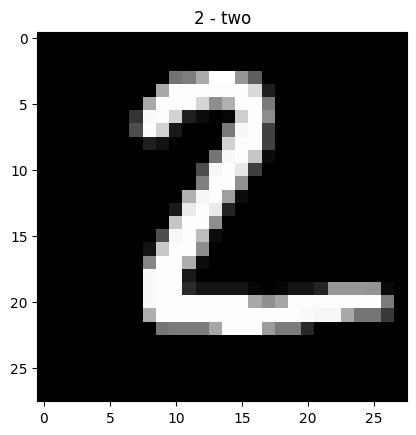

In [29]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

In [33]:
model.eval()
with torch.inference_mode():
  y_pred = model(X)

In [45]:
pred_label = y_pred.argmax(dim=1)[1]

In [46]:
print(f"Prediction: {class_names[pred_label]}")

Prediction: 2 - two


# Confusion Matrix

In [47]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [48]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.5 MB/s eta 0:00:00
mlxtend version: 0.23.1


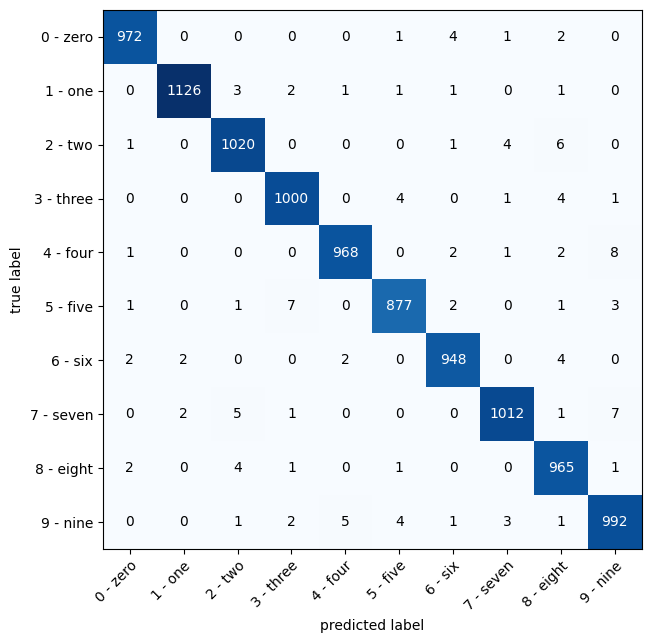

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Saving and Loading Model

In [50]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "mnist_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/mnist_cnn_model.pth


In [51]:
loaded_model = TinyVGG(input_shape=1,
                                    hidden_units=10,
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model = loaded_model.to(device)

In [52]:
loaded_model

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=490, out_features=10, bias=True)
)

In [53]:
model.eval()
with torch.inference_mode():
  y_pred = loaded_model(X)

pred_label = y_pred.argmax(dim=1)[1]
print(f"Prediction using Loaded Model: {class_names[pred_label]}")

Prediction using Loaded Model: 2 - two
